In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import sys

sys.path.append('/workspace/deep_birth_death/src')

from evaluation.classification import get_MLE_classification_results, plot_conf_mat

### Data Loading and Preprocessing

In [3]:
n_tips = [674, 489, 87]
div_scenarios = ["BD", "HE", "ME", "SAT", "SR", "WW"]

scenario_to_idx = {scen: i for i, scen in enumerate(div_scenarios)}


likelihood_model_names = ["cbd", "ME", "shift", "SAT"]

model_selection_results = dict()
classified_unknown = dict()

for tip in n_tips:
    model_selection_results[tip] = dict()
    classified_unknown[tip] = dict()
    
    model_selection_results[tip]["y_pred"] = []
    model_selection_results[tip]["y_test"] = []

    
    for div in div_scenarios:
        classified_unknown[tip][div] = dict()
        classified_unknown[tip][div] = 0 
        
        #Load inference data      
        treepar_file_path = "/workspace/deep_birth_death/MLE/inference_data/" + str(tip) + "/TreePar_inference_" + str(tip) + "_" + div + ".csv"
        dd_file_path = "/workspace/deep_birth_death/MLE/inference_data/" + str(tip) + "/DDD_inference_" + str(tip) + "_" + div + ".csv"
        
        df_tp = pd.read_csv(treepar_file_path)
        df_dd = pd.read_csv(dd_file_path)
        
        classified_unknow = 0
        df_merged = df_tp.merge(df_dd[['AIC']], left_index=True, right_index=True, how='inner', suffixes=('_tp', '_dd'))
        
        #Model selection based on AIC criteria
        for i, row in df_merged.iterrows():
            aic_values = np.array([
                row["aic_cbd"],
                row["aic_me"],
                row["aic_shift"],
                row["AIC"] 
            ])
            
            
            best_idx = np.argmin(aic_values)  
            best_model = likelihood_model_names[best_idx]
            
            if best_model == "cbd":
                estimated_a = row["estimated_a"]
                estimated_r = row["estimated_r"]
                
                if estimated_r < 0 or estimated_a < 0:
                    best_model = "unknown"
                elif estimated_a > 0.8:
                    best_model = "HE"
                else:
                    best_model = "BD"
                    
            if best_model == "shift":
                estimated_r0 = row["estimated_r0"]
                estimated_r1 = row["estimated_r1"]
                if estimated_r0 < 0 and estimated_r1 > 0:
                    best_model = "WW"
                elif estimated_r0 > 0 and estimated_r1 > 0: 
                    best_model = "SR"
                else: 
                    best_model = "unknow"
                    
            #Split the unknow predicted scenarios
            if best_model == "unknow": 
                 classified_unknown[tip][div] += 1
            
            #Save the correct scenarios 
            else:
                real_scenario = str(div)
                model_selection_results[tip]["y_pred"].append(scenario_to_idx[best_model])
                model_selection_results[tip]["y_test"].append(scenario_to_idx[real_scenario])
                    
        
    #Save the model selection results
    report = classification_report(model_selection_results[tip]["y_test"],  model_selection_results[tip]["y_pred"], output_dict=True)

    
    model_selection_results[tip]['accuracy'] = report['accuracy']
    model_selection_results[tip]['f1-score'] = report['macro avg']['f1-score']
    model_selection_results[tip]['recall'] = report['macro avg']['recall']
    model_selection_results[tip]['precision'] = report['macro avg']['precision']

### Results generation

In [4]:
df = pd.DataFrame.from_dict(classified_unknown, orient='index')
print("Unknown scenarios predicted by TreePar")
df.T

Unknown scenarios predicted by TreePar


,674,489,87
BD,6,4,6
HE,4,4,2
ME,6,7,17
SAT,0,0,0
SR,22,22,34
WW,0,0,0


In [5]:
get_MLE_classification_results(model_selection_results)

,674,489,87
accuracy,0.731317,0.740675,0.715342
F1-Score,0.732764,0.739463,0.694824
Recall,0.733054,0.741836,0.694126
Precision,0.808988,0.806344,0.726768


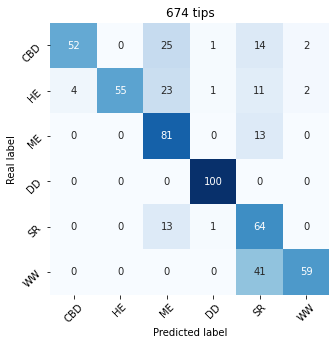

              precision    recall  f1-score   support

           0     0.9286    0.5532    0.6933        94
           1     1.0000    0.5729    0.7285        96
           2     0.5704    0.8617    0.6864        94
           3     0.9709    1.0000    0.9852       100
           4     0.4476    0.8205    0.5792        78
           5     0.9365    0.5900    0.7239       100

    accuracy                         0.7313       562
   macro avg     0.8090    0.7331    0.7328       562
weighted avg     0.8230    0.7313    0.7397       562



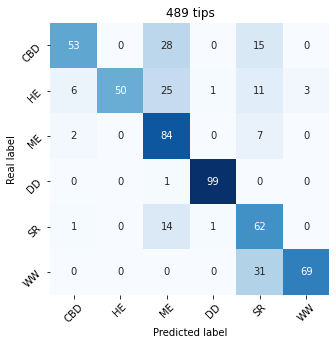

              precision    recall  f1-score   support

           0     0.8548    0.5521    0.6709        96
           1     1.0000    0.5208    0.6849        96
           2     0.5526    0.9032    0.6857        93
           3     0.9802    0.9900    0.9851       100
           4     0.4921    0.7949    0.6078        78
           5     0.9583    0.6900    0.8023       100

    accuracy                         0.7407       563
   macro avg     0.8063    0.7418    0.7395       563
weighted avg     0.8201    0.7407    0.7461       563



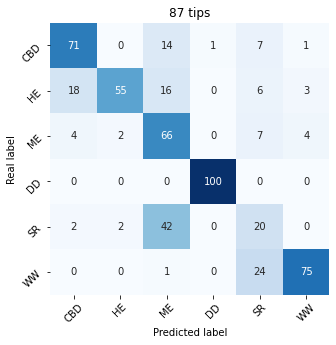

              precision    recall  f1-score   support

           0     0.7474    0.7553    0.7513        94
           1     0.9322    0.5612    0.7006        98
           2     0.4748    0.7952    0.5946        83
           3     0.9901    1.0000    0.9950       100
           4     0.3125    0.3030    0.3077        66
           5     0.9036    0.7500    0.8197       100

    accuracy                         0.7153       541
   macro avg     0.7268    0.6941    0.6948       541
weighted avg     0.7597    0.7153    0.7217       541



In [6]:
label_names = ["CBD", "HE", "ME", "DD", "SR", "WW"]
for tip in n_tips:
    plot_conf_mat(model_selection_results[tip]["y_pred"], model_selection_results[tip]["y_test"], label_names, str(tip))

In [7]:
for tip in n_tips:
    print(np.shape(model_selection_results[tip]["y_pred"]))
    print(np.shape(model_selection_results[tip]["y_test"]))

(562,)
(562,)
(563,)
(563,)
(541,)
(541,)
